# Installations

In [1]:
!pip install opencv-contrib-python
!pip install numpy==1.23.5 scipy==1.10.0 open3d==0.16.0

# Import statements

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import pickle
import open3d as o3d

# Global variables

In [3]:
# Define the path to your stereo images
stereo_images_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Stereo images'

# Filenames of the stereo images
filenames = [
    'SideA_LeftCam.jpg', 'SideA_RightCam.jpg',
    'SideB_LeftCam.jpg', 'SideB_RightCam.jpg',
    'SideC_LeftCam.jpg', 'SideC_RightCam.jpg',
    'SideD_LeftCam.jpg', 'SideD_RightCam.jpg'
]

# Define the path to your calibration images
calibration_images_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Checkerboard/Large checkerboard/Version 2/Original'

# Filenames of the calibration images
calibration_filenames = [
    'Calibration_A_LC.jpg', 'Calibration_A_RC.jpg',
    'Calibration_B_LC.jpg', 'Calibration_B_RC.jpg',
    'Calibration_C_LC.jpg', 'Calibration_C_RC.jpg',
    'Calibration_D_LC.jpg', 'Calibration_D_RC.jpg',
    'Calibration_E_LC.jpg', 'Calibration_E_RC.jpg'
]

# Define the path to save segmented images
segmented_images_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Segmented plants'

# Define the path to save depth maps
depth_maps_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Depth maps'

# Define the path to save point clouds
point_clouds_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Point clouds'

# Define the path to save the merged point cloud
merged_pc_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Single point cloud'

# Define the path to save the meshed model
meshed_model_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Meshed point cloud'

In [8]:
# Define the scaling percentage for resizing images
scale_percent = 25  # Adjust as needed (e.g., 25%, 50%)

# Functions

## Preliminaries

In [4]:
# A function to resize images
def resize_image(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    return resized_image

In [5]:
# Display the images
def display_images(images, titles):
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(images):
        plt.subplot(2, 4, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Camera Calibration, and Image Rectification

## Image Segmentation

In [ ]:
# Placeholder for your segmentation model
def segment_plant(image):
    # TODO: Replace this function with your own segmentation code
    # For example:
    # model = load_your_model()
    # mask = model.predict(image)
    # segmented_image = apply_mask(image, mask)
    # return segmented_image
    print("Please replace the 'segment_plant' function with your segmentation model.")
    return image  # This returns the original image as a placeholder

## Depth Map Generation

## Point Cloud Generation

## Point Cloud Registration

## Mesh Generation

# Program start

## Preliminaries

### Mount Google Drive

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Retrieve stereo images

In [9]:
# Load and resize the images
stereo_images = []
for filename in filenames:
    image_path = os.path.join(stereo_images_path, filename)
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        # Resize the image
        img_resized = resize_image(img, scale_percent)
        stereo_images.append(img_resized)
    else:
        print(f"Error: {filename} not found at {image_path}")

### Display stereo images

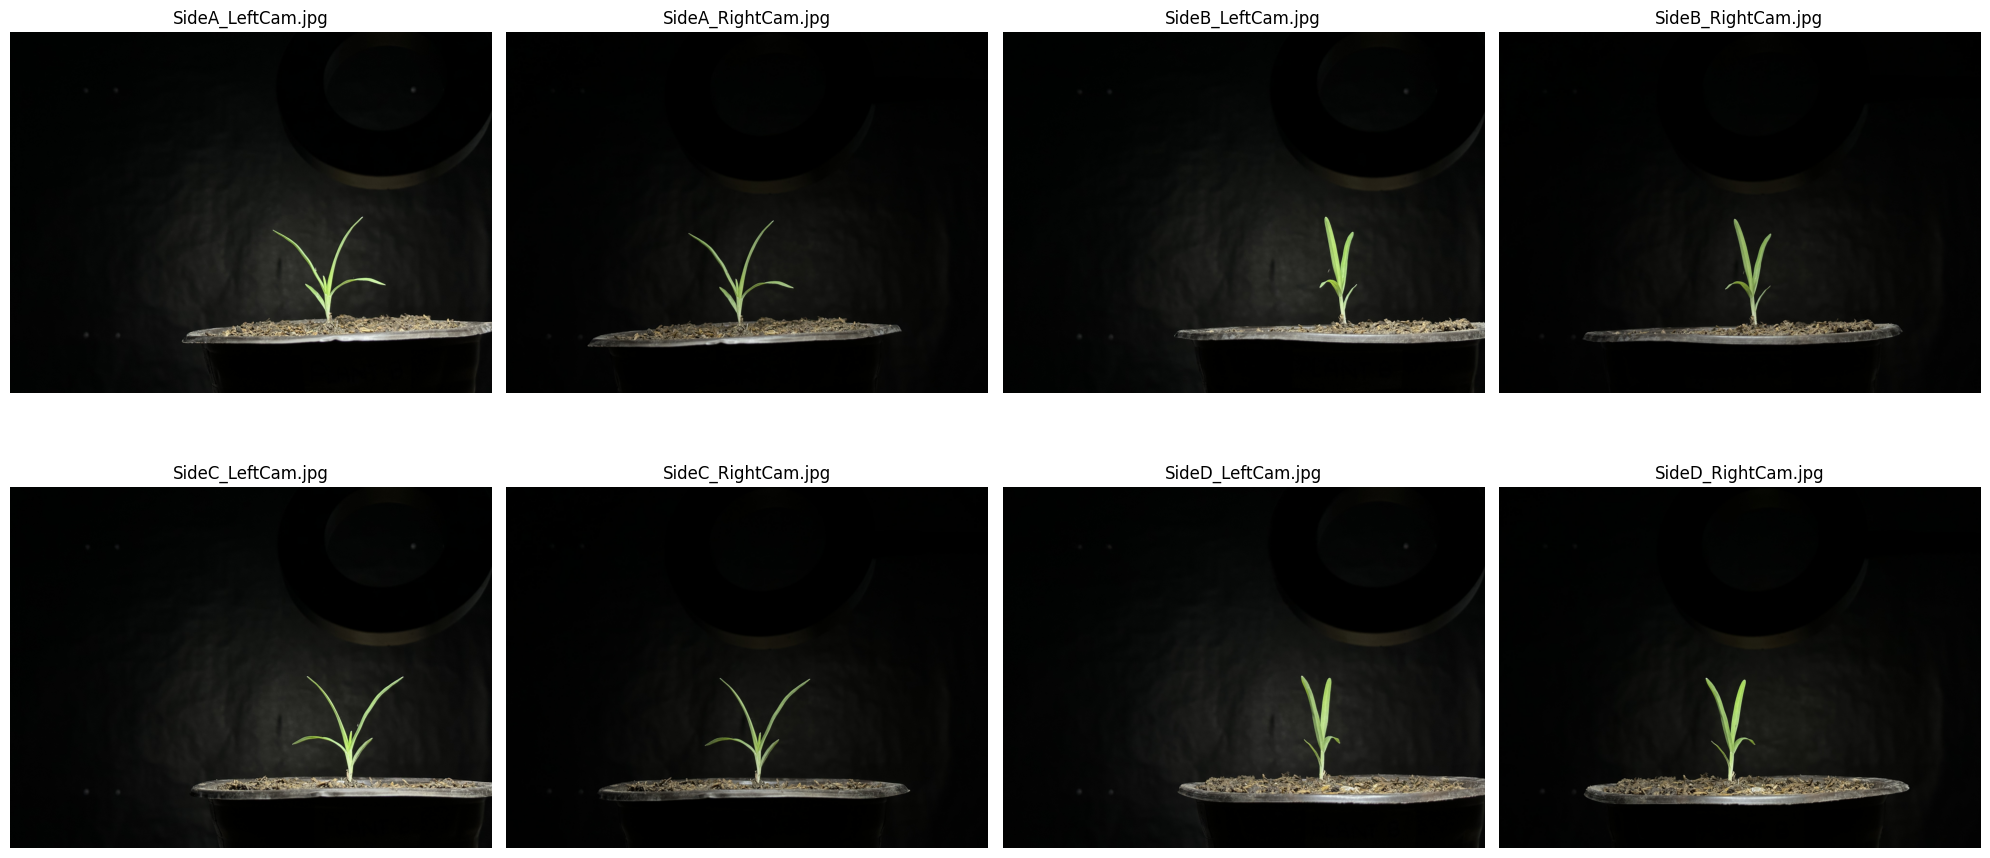

In [10]:
titles = filenames
display_images(stereo_images, titles)

## Camera Calibration, and Image Rectification

Error: Chessboard corners not found in calibration image pair 1.


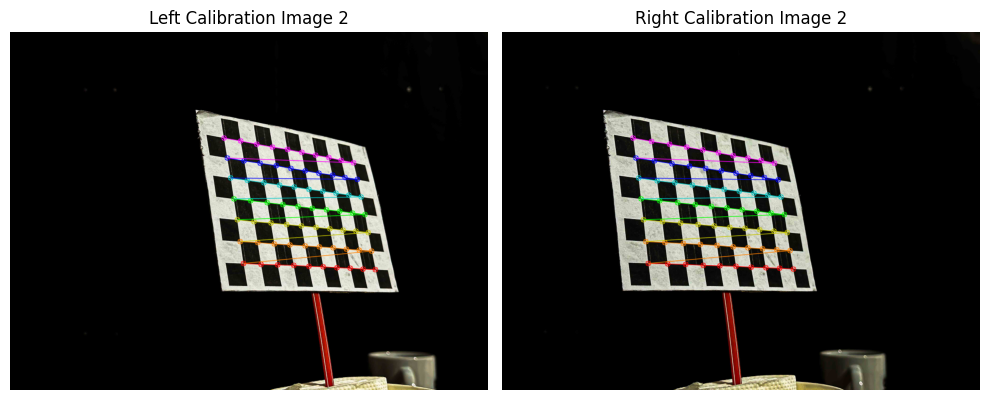

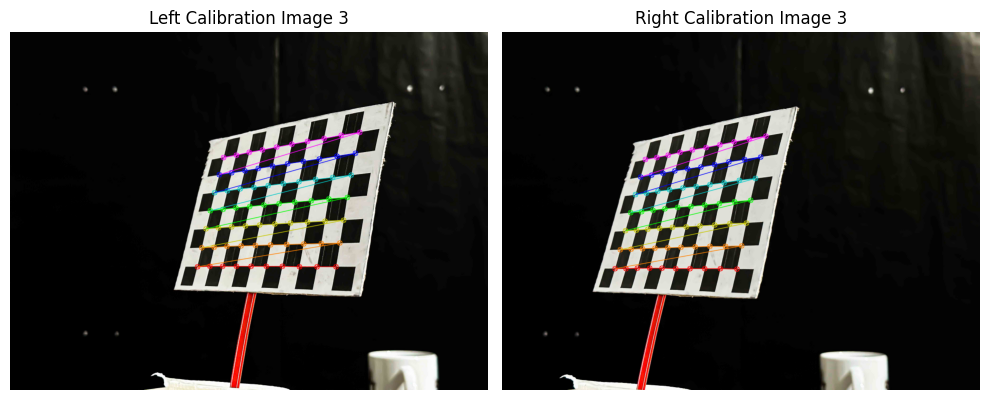

Error: Chessboard corners not found in calibration image pair 4.
Error: Chessboard corners not found in calibration image pair 5.


In [11]:
# Load and resize calibration images
left_calib_images = []
right_calib_images = []
for i in range(0, len(calibration_filenames), 2):
    left_img_path = os.path.join(calibration_images_path, calibration_filenames[i])
    right_img_path = os.path.join(calibration_images_path, calibration_filenames[i+1])
    if os.path.exists(left_img_path) and os.path.exists(right_img_path):
        left_img = cv2.imread(left_img_path)
        right_img = cv2.imread(right_img_path)
        # Resize images
        left_img_resized = resize_image(left_img, scale_percent)
        right_img_resized = resize_image(right_img, scale_percent)
        left_calib_images.append(left_img_resized)
        right_calib_images.append(right_img_resized)
    else:
        print(f"Error: Calibration images {calibration_filenames[i]} or {calibration_filenames[i+1]} not found.")

# Camera calibration parameters
checkerboard_size = (10, 7)  # Internal corners per chessboard row and column
square_size = 12.5  # Size of a square in your defined unit (cm)

# Prepare object points
objp = np.zeros((checkerboard_size[0]*checkerboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1, 2)
objp *= square_size

# Arrays to store object points and image points
objpoints = []        # 3d point in real world space
imgpoints_left = []   # 2d points in image plane.
imgpoints_right = []

# Termination criteria for corner refinement
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Find chessboard corners and calibrate
for idx, (left_img, right_img) in enumerate(zip(left_calib_images, right_calib_images)):
    gray_left = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

    ret_left, corners_left = cv2.findChessboardCorners(gray_left, checkerboard_size, None)
    ret_right, corners_right = cv2.findChessboardCorners(gray_right, checkerboard_size, None)

    if ret_left and ret_right:
        objpoints.append(objp)

        # Refine corner locations
        corners_left = cv2.cornerSubPix(gray_left, corners_left, (11,11), (-1,-1), criteria)
        corners_right = cv2.cornerSubPix(gray_right, corners_right, (11,11), (-1,-1), criteria)

        imgpoints_left.append(corners_left)
        imgpoints_right.append(corners_right)

        # Optional: Draw and display the corners
        cv2.drawChessboardCorners(left_img, checkerboard_size, corners_left, ret_left)
        cv2.drawChessboardCorners(right_img, checkerboard_size, corners_right, ret_right)

        # Display the images with detected corners
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
        axs[0].set_title(f'Left Calibration Image {idx+1}')
        axs[0].axis('off')

        axs[1].imshow(cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB))
        axs[1].set_title(f'Right Calibration Image {idx+1}')
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Error: Chessboard corners not found in calibration image pair {idx+1}.")

# Check if sufficient valid pairs were found
if len(objpoints) < 1:
    print("Error: Not enough valid calibration images for stereo calibration.")
else:
    # Stereo calibration
    ret, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F = cv2.stereoCalibrate(
        objpoints,
        imgpoints_left,
        imgpoints_right,
        None, None, None, None,
        gray_left.shape[::-1],
        criteria=criteria,
        flags=cv2.CALIB_FIX_INTRINSIC
    )

    # Stereo rectification
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        cameraMatrix1, distCoeffs1,
        cameraMatrix2, distCoeffs2,
        gray_left.shape[::-1], R, T
    )

    # Save calibration data if needed
    calibration_data_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Preliminaries/calibration_data.pkl'
    with open(calibration_data_path, 'wb') as f:
        pickle.dump({
            'cameraMatrix1': cameraMatrix1,
            'distCoeffs1': distCoeffs1,
            'cameraMatrix2': cameraMatrix2,
            'distCoeffs2': distCoeffs2,
            'R': R, 'T': T, 'R1': R1, 'R2': R2, 'P1': P1, 'P2': P2, 'Q': Q
        }, f)

## Image Segmentation

### Segment plant objects

In [ ]:
# Segment the images
segmented_images = []
for img in stereo_images:
    segmented_img = segment_plant(img)
    segmented_images.append(segmented_img)

### Save segmented images

In [ ]:
# Create directory if it doesn't exist
os.makedirs(segmented_images_path, exist_ok=True)

# Save the segmented images
for i, img in enumerate(segmented_images):
    save_path = os.path.join(segmented_images_path, f'Segmented_{filenames[i]}')
    cv2.imwrite(save_path, img)

### Display segmented images

In [ ]:
# Display the segmented images
display_images(segmented_images, [f'Segmented {title}' for title in titles])

## Depth Map Generation

### Generate depth maps

In [ ]:
# Load calibration data
with open(calibration_data_path, 'rb') as f:
    calib_data = pickle.load(f)
    cameraMatrix1 = calib_data['cameraMatrix1']
    distCoeffs1 = calib_data['distCoeffs1']
    cameraMatrix2 = calib_data['cameraMatrix2']
    distCoeffs2 = calib_data['distCoeffs2']
    R1 = calib_data['R1']
    R2 = calib_data['R2']
    P1 = calib_data['P1']
    P2 = calib_data['P2']
    Q = calib_data['Q']

# Initialize StereoSGBM matcher with adjusted parameters
image_height, image_width = segmented_images[0].shape[:2]
num_disparities = ((image_width // 8) + 15) & -16  # Ensure it's divisible by 16
block_size = 5  # Adjust as needed

stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=num_disparities,
    blockSize=block_size,
    P1=8 * 3 * block_size ** 2,
    P2=32 * 3 * block_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)

depth_maps = []
for i in range(0, len(segmented_images), 2):
    # Undistort and rectify images
    left_img = segmented_images[i]
    right_img = segmented_images[i+1]

    # Convert to grayscale
    gray_left = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

    # Compute disparity map
    disparity_map = stereo.compute(gray_left, gray_right).astype(np.float32) / 16.0
    depth_maps.append(disparity_map)

### Save depth maps

In [ ]:
# Create directory if it doesn't exist
os.makedirs(depth_maps_path, exist_ok=True)

# Save the depth maps
for i, depth_map in enumerate(depth_maps):
    save_path = os.path.join(depth_maps_path, f'DepthMap_{i+1}.png')
    # Normalize the disparity map for visualization
    norm_depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite(save_path, norm_depth_map.astype(np.uint8))

### Display depth maps

In [ ]:
# Display the depth maps
for i, depth_map in enumerate(depth_maps):
    plt.figure(figsize=(10, 5))
    plt.imshow(depth_map, 'gray')
    plt.title(f'Depth Map {i+1}')
    plt.axis('off')
    plt.show()

## Point Cloud Generation

### Generate point clouds

In [ ]:
point_clouds = []
for idx, depth_map in enumerate(depth_maps):
    # Get corresponding left image for colors
    color_image = segmented_images[idx*2]

    # Reproject to 3D
    points_3D = cv2.reprojectImageTo3D(depth_map, Q)
    mask = depth_map > depth_map.min()

    # Apply mask to points and colors
    points = points_3D[mask]
    colors = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
    colors = colors[mask]

    # Create Open3D point cloud
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(points)
    pc.colors = o3d.utility.Vector3dVector(colors / 255.0)
    point_clouds.append(pc)

### Save point clouds

In [ ]:
# Create directory if it doesn't exist
os.makedirs(point_clouds_path, exist_ok=True)

# Save the point clouds
for i, pc in enumerate(point_clouds):
    save_path = os.path.join(point_clouds_path, f'PointCloud_{i+1}.ply')
    o3d.io.write_point_cloud(save_path, pc)

### Display point clouds

In [ ]:
# Display the point clouds
for i, pc in enumerate(point_clouds):
    print(f'Displaying Point Cloud {i+1}')
    o3d.visualization.draw_geometries([pc])

## Point Cloud Registration

### Merge point clouds

In [ ]:
# Merge the point clouds using ICP registration
merged_pc = point_clouds[0]
for i in range(1, len(point_clouds)):
    print(f'Registering Point Cloud {i+1} to the merged point cloud')
    threshold = 0.02  # Adjust as needed
    trans_init = np.eye(4)
    reg_p2p = o3d.pipelines.registration.registration_icp(
        point_clouds[i], merged_pc, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint()
    )
    print(f'Transformation Matrix for Point Cloud {i+1}:\n', reg_p2p.transformation)
    point_clouds[i].transform(reg_p2p.transformation)
    merged_pc += point_clouds[i]
    merged_pc = merged_pc.voxel_down_sample(voxel_size=0.005)

### Save merged point cloud

In [ ]:
# Create directory if it doesn't exist
os.makedirs(merged_pc_path, exist_ok=True)

# Save the merged point cloud
save_path = os.path.join(merged_pc_path, 'MergedPointCloud.ply')
o3d.io.write_point_cloud(save_path, merged_pc)

### Display merged point cloud

In [ ]:
# Display the merged point cloud
print("Displaying the merged point cloud")
o3d.visualization.draw_geometries([merged_pc])

## Mesh Generation

### Generate mesh from merged point cloud

In [ ]:
# Generate mesh using Poisson surface reconstruction
print("Generating mesh from the merged point cloud...")
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug):
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        merged_pc, depth=9
    )

# Remove low-density vertices to clean up the mesh
vertices_to_remove = densities < np.quantile(densities, 0.01)
mesh.remove_vertices_by_mask(vertices_to_remove)

### Save 3D mesh model

In [ ]:
# Create directory if it doesn't exist
os.makedirs(meshed_model_path, exist_ok=True)

# Save the meshed model
save_path = os.path.join(meshed_model_path, 'MeshedModel.ply')
o3d.io.write_triangle_mesh(save_path, mesh)

### Display 3D mesh model

In [ ]:
# Display the meshed model
print("Displaying the meshed model")
o3d.visualization.draw_geometries([mesh])